In [12]:
# A 360*480 pic.jpg is required.

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import numpy as np
from PIL import Image

img = np.array(Image.open('pic.jpg'))

import math
# 参考了网络学堂上助教给出的代码
class my_PCA(object):
    def __init__(self,n_components):
        self.n_components = n_components      
    
    def svd_solver(self, data):
        mean=np.mean(data,axis=0)
        data=data-mean[np.newaxis,:]                                                 #同上操作
        eig_vectors,eig_values,v=np.linalg.svd(data.T)                               #使用numpy中的SVD方法做SVD
        self.proj_matrix=eig_vectors[:,:self.n_components]                           #挑选n_components个向量进行投影
        # self.proj_matrix = self.proj_matrix/np.sqrt(eig_values[:self.n_components])  #白化
                                     

    def transform(self, data):
        mean=np.mean(data,axis=0)
        data=data-mean[np.newaxis,:]                       #均值归一化为0
        new_data=data.dot(self.proj_matrix)                #将数据投影到新方向
        return new_data    


In [7]:
# 定义底层函数：
# PCA_compress：对图像的三个通道使用PCA求取投影矩阵
# PCA_rebuild：返回PCA处理后图像的三个通道，与PCA_compress连用
# img_segmentation：图像分块
# img_composition：图像拼接
# 压缩比定义为原图像素数与PCA各主分量矩阵元素数目和与投影系数数目和的商
def PCA_compress(data_R,data_G,data_B,num_components):

    pca_R = my_PCA(n_components=num_components)
    pca_R.svd_solver(data_R)
    factor_R = pca_R.transform(data_R)
    pca_G = my_PCA(n_components=num_components)
    pca_G.svd_solver(data_G)
    factor_G = pca_G.transform(data_G)
    pca_B = my_PCA(n_components=num_components)
    pca_B.svd_solver(data_B)
    factor_B = pca_B.transform(data_B)
    
    compress_ratio = data_R.size / (factor_R.size + pca_R.proj_matrix.size)

    return pca_R.proj_matrix, factor_R, pca_G.proj_matrix, factor_G, pca_B.proj_matrix, factor_B, compress_ratio

def PCA_rebuild(proj_matrix_R, factor_R, proj_matrix_G, factor_G, proj_matrix_B, factor_B):
    rebuild_R = np.dot(factor_R, proj_matrix_R.T)
    rebuild_G = np.dot(factor_G, proj_matrix_G.T)
    rebuild_B = np.dot(factor_B, proj_matrix_B.T)
    return rebuild_R, rebuild_G, rebuild_B

def img_segmentation(mat, W_num, H_num):
    W = int(mat.shape[0] / W_num)
    H = int(mat.shape[1] / H_num)
    img_seged = np.zeros((W_num * H_num, W * H))
    for x in range(W_num):
        for y in range(H_num):
            img_seged[x * W_num + y, :] = np.reshape(mat[x * W:(x + 1) * W, y * H:(y + 1) * H], W * H)
    return img_seged

def img_composition(mat, W_num, H_num, W, H):
    img_comed = np.zeros((W_num * W, H_num * H))
    for x in range(W_num):
        for y in range(H_num):
            img_comed[x * W:(x + 1) * W, y * H:(y + 1) * H] = np.reshape(mat[x * W_num + y, :], (W, H))
    return img_comed



In [10]:
# 定义损失函数和主接口；
# loss：损失函数，图片中所有像素每个像素差值的平均值
# main：主函数，输入img，分块数量和保留主分量数目，返回重构图像，压缩比，loss，R通道投影矩阵
def loss(img,rebuild_img):
    loss = np.mean(np.abs(img - rebuild_img))
    return loss

def main(img, n_seg, n_com):
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]

    W, H = img_B.shape
    
    data_R = img_segmentation(img_R, n_seg, n_seg)
    data_G = img_segmentation(img_G, n_seg, n_seg)
    data_B = img_segmentation(img_B, n_seg, n_seg)

    proj_matrix_R,factor_R,proj_matrix_G,factor_G,proj_matrix_B,factor_B,compress_ratio=PCA_compress(data_R,data_G,data_B,n_com)
    rebuild_data_R,rebuild_data_G,rebuild_data_B=PCA_rebuild(proj_matrix_R,factor_R,proj_matrix_G,factor_G,proj_matrix_B,factor_B)

    rebuild_img_R=np.clip(img_composition(rebuild_data_R,n_seg,n_seg,int(W/n_seg),int(H/n_seg))/255,0,1)
    rebuild_img_G=np.clip(img_composition(rebuild_data_G,n_seg,n_seg,int(W/n_seg),int(H/n_seg))/255,0,1)
    rebuild_img_B=np.clip(img_composition(rebuild_data_B,n_seg,n_seg,int(W/n_seg),int(H/n_seg))/255,0,1)

    rebuild_img=np.concatenate((rebuild_img_R[:,:,np.newaxis],rebuild_img_G[:,:,np.newaxis],rebuild_img_B[:,:,np.newaxis]),axis=-1)
    
    return rebuild_img,compress_ratio,loss(img/255,rebuild_img),proj_matrix_R

In [16]:
#不同分块数以及不同主成分个数下的实验
spilit_list = [6, 12, 24, 120]
num_list = [5, 10, 15, 20]
acc_list = np.zeros((len(spilit_list),len(num_list)))
ratio_list = np.zeros((len(spilit_list),len(num_list)))
for i in range(len(spilit_list)):
    for j in range(len(num_list)):
        _,compress_ratio,acc,_=main(img,spilit_list[i],num_list[j])        
        ratio_list[i][j]=compress_ratio
        acc_list[i][j]=acc

C:\Users\pikachu\AppData\Local\Temp/ipykernel_18512/1189803808.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\pikachu\AppData\Local\Temp/ipykernel_18512/1189803808.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0.92, 'Compression Ratio')

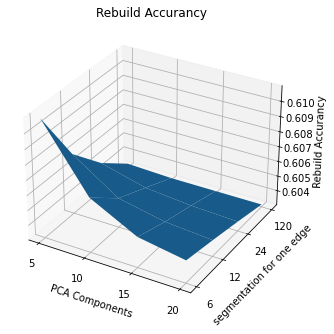

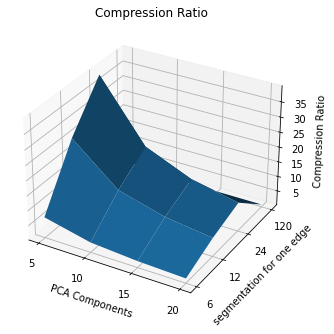

In [19]:
#绘图
from mpl_toolkits.mplot3d import Axes3D

x, y = np.meshgrid(range(len(num_list)),range(len(spilit_list)))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, acc_list)

ax.set_xlabel('PCA Components')
ax.set_ylabel('segmentation for one edge')
ax.set_zlabel('Rebuild Accurancy')
ax.set_xticks(range(len(num_list)))
ax.set_yticks(range(len(spilit_list)))
ax.set_xticklabels(num_list)
ax.set_yticklabels(spilit_list)
plt.title('Rebuild Accurancy')

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, ratio_list)
ax.set_xlabel('PCA Components')
ax.set_ylabel('segmentation for one edge')
ax.set_zlabel('Compression Ratio')
ax.set_xticks(range(len(num_list)))
ax.set_yticks(range(len(spilit_list)))
ax.set_xticklabels(num_list)
ax.set_yticklabels(spilit_list)
plt.title('Compression Ratio')

### 实验方法
1. 对彩色图像三通道分离操作
2. 首先对图像矩阵进行分块，小块reshape为一个列向量，将所有小块对应列向量合并成矩阵做PCA。
3. 最后重建图像，用投影系数对投影矩阵的各分量进行线性叠加，即可得到重建后的图像。
### 实验结果
从结果来看：相同分块数目时，选取主成分数目越多，重建效果越好，相应的压缩比则会下降；相同主成分数目时，图像分块增多时，压缩比首先会上升，因分块增多导致每个主成分维度降低，但分块数目超过一定阈值后，压缩比反而下降，因分块增多导致需要存储的投影系数增多。
在实际应用中，应当选择适中的分块数目。对于主成分数目，如果希望获得好的重建质量，则应取较大值；如果希望获得较高的压缩比，则应取较小值。